In [1]:
import os
from google.colab import files

import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import ImageFile

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.metrics import confusion_matrix, classification_report

In [5]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download -d kaustubhb999/tomatoleaf -p /content/images/ --unzip

 94% 169M/179M [00:01<00:00, 129MB/s]
100% 179M/179M [00:01<00:00, 121MB/s]


In [2]:
def define_paths(dir):
    files_path = []
    classes = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        file_list = os.listdir(folder_path)
        for file_name in file_list:
            fpath = os.path.join(folder_path, file_name)
            files_path.append(fpath)
            classes.append(folder)
    return files_path, classes

def define_df(files, classes):
    file_series = pd.Series(files, name= 'file_paths')
    class_series = pd.Series(classes, name='class')
    return pd.concat([file_series, class_series], axis= 1)

def make_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [7]:
train_dir = '/content/images/tomato/train'
valid_dir = '/content/images/tomato/val'
temp_df = make_df(train_dir)
test_df = make_df(valid_dir)

train_df, valid_df = train_test_split(temp_df, train_size=0.9, shuffle=True, random_state=42, stratify=temp_df['class'])

In [8]:

print(train_df.groupby(['class']).count())
print('Train set minimum class count : ', train_df.groupby(['class']).count().min())
print(valid_df.groupby(['class']).count())
print('Validation set minimum class count:', valid_df.groupby(['class']).count().min())
print(test_df.groupby(['class']).count())
print('Test set minimum class count:', test_df.groupby(['class']).count().min())

                                               file_paths
class                                                    
Tomato___Bacterial_spot                               900
Tomato___Early_blight                                 900
Tomato___Late_blight                                  900
Tomato___Leaf_Mold                                    900
Tomato___Septoria_leaf_spot                           900
Tomato___Spider_mites Two-spotted_spider_mite         900
Tomato___Target_Spot                                  900
Tomato___Tomato_Yellow_Leaf_Curl_Virus                900
Tomato___Tomato_mosaic_virus                          900
Tomato___healthy                                      900
Train set minimum class count :  file_paths    900
dtype: int64
                                               file_paths
class                                                    
Tomato___Bacterial_spot                               100
Tomato___Early_blight                                 100
Tomato__

In [9]:
img_size = (224, 224)
batch = 40
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

tr_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True)

ts_and_vl_datagen = ImageDataGenerator(rescale=1./255)
print('For train')
train_generator = tr_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    class_mode='categorical')

print('\nFor validation')
validation_generator = ts_and_vl_datagen.flow_from_dataframe(
    valid_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=False,
    class_mode='categorical')

print('\nFor test')
test_generator = ts_and_vl_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch,
    shuffle=False,
    class_mode='categorical')

For train
Found 9000 validated image filenames belonging to 10 classes.

For validation
Found 1000 validated image filenames belonging to 10 classes.

For test
Found 1000 validated image filenames belonging to 10 classes.


In [10]:
def show_sample_images(generator, num_sample=30):
    class_list = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize= (25, 15))
    length = len(labels)
    sample = min(length, 30)
    for i in range(sample):
        plt.subplot(5, 6, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name, color= 'green', fontsize= 12)
        plt.axis('off')
    plt.show()

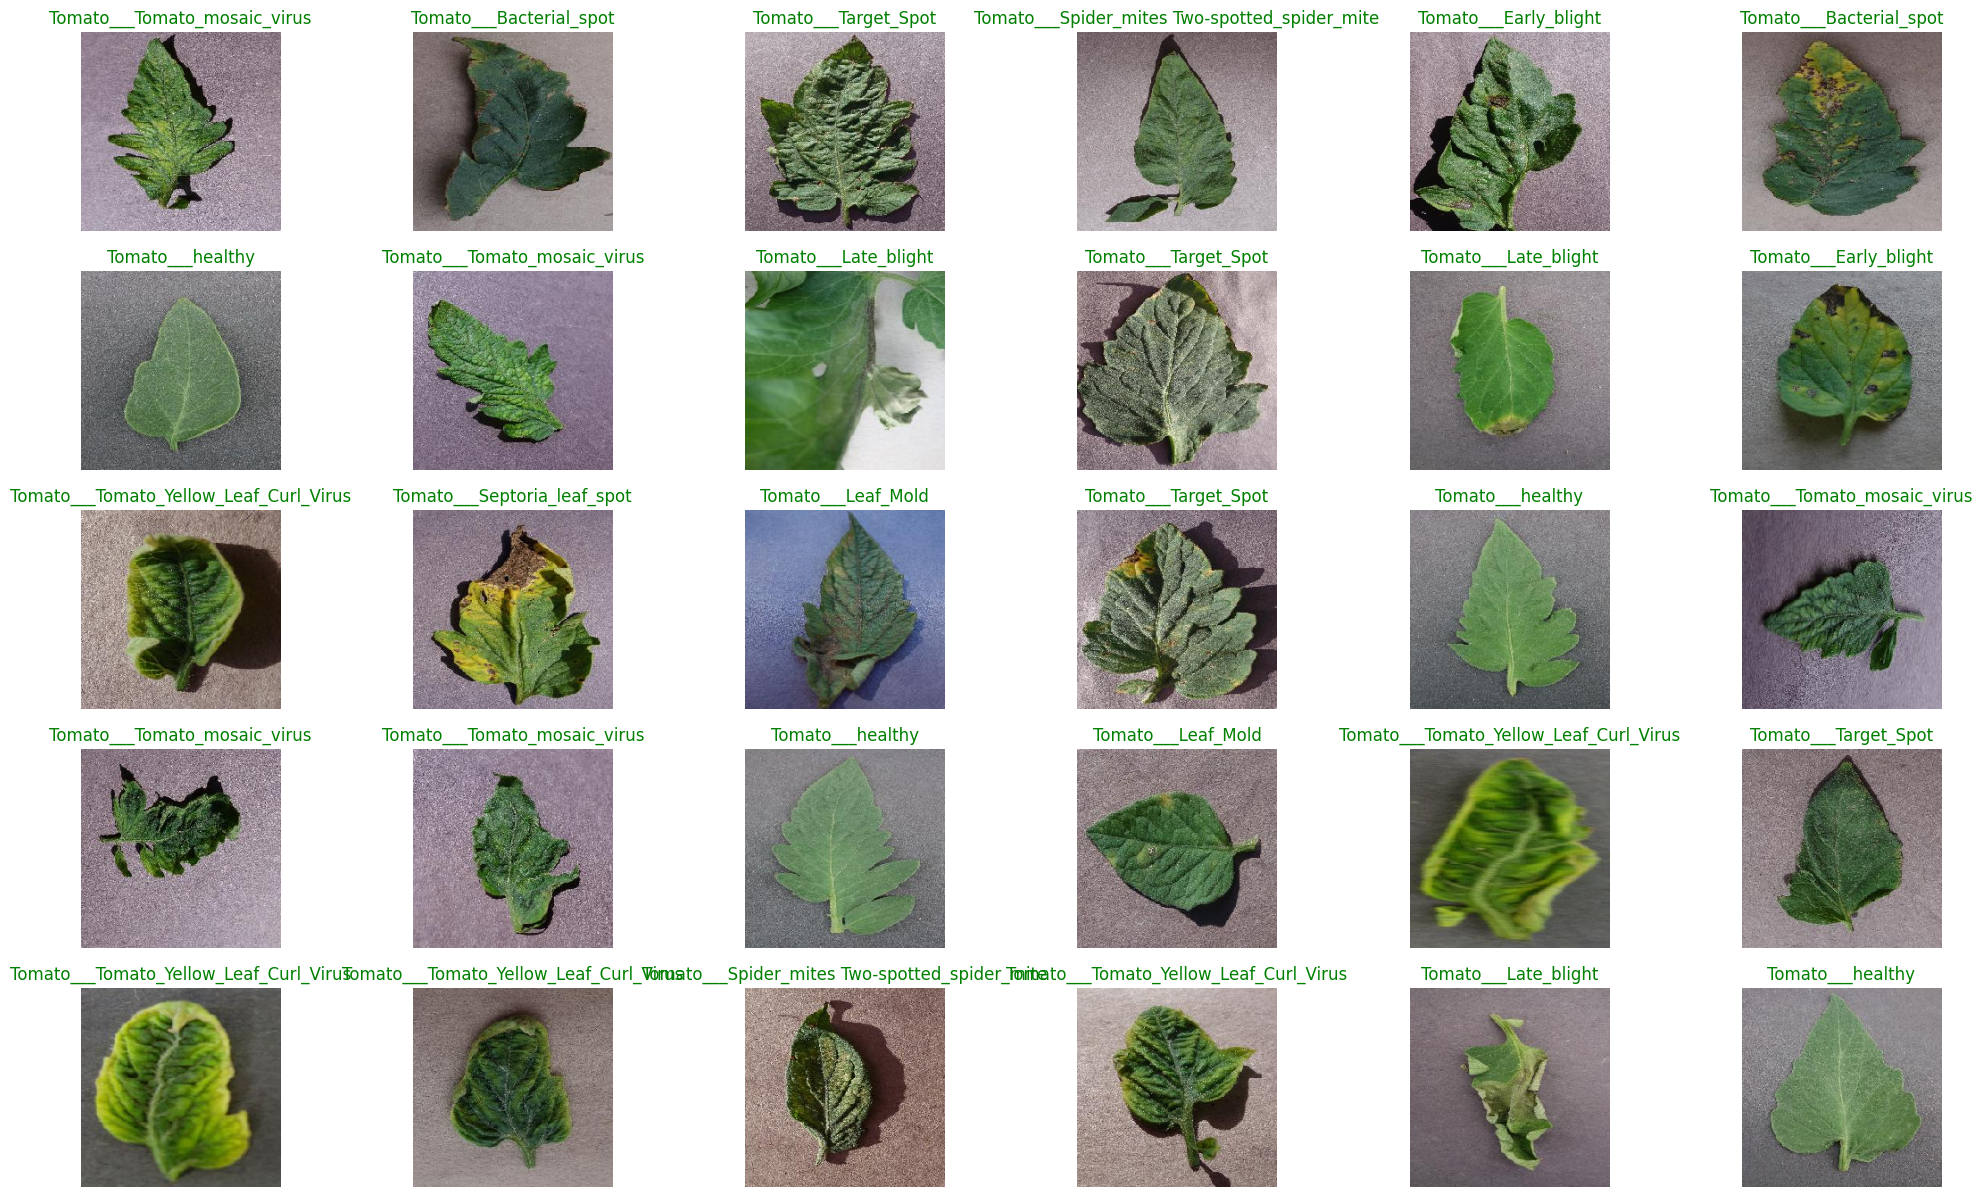

In [11]:
show_sample_images(train_generator)

In [12]:
def create_model(transfer_model):
    img_shape = (224, 224, 3)
    class_num = len(list(train_generator.class_indices.keys()))
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)

    base_model.trainable = False

    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(256,
            kernel_regularizer=regularizers.L2(0.015),
            activity_regularizer= regularizers.L1(0.005),
            bias_regularizer= regularizers.L1(0.005),
            activation= 'relu'),
      Dropout(rate= 0.4, seed= 123),
      Dense(class_num, activation= 'softmax')
    ])

    return model

## For Mobile Net

In [13]:
mobilenet = create_model("MobileNetV2")
mobilenet.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics= ['accuracy'])

mobilenet.summary()
mobilenet.layers[0].summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                           

In [14]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached 97%!")
            self.model.stop_training = True

my_callbacks = MyCallback()

In [15]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
initial_epochs = 50
history_mobilenet = mobilenet.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=initial_epochs,
    verbose=2,
    callbacks=[my_callbacks],
    validation_steps= None,
    shuffle= False,
)

Epoch 1/50
225/225 - 31s - loss: 3.0003 - accuracy: 0.7001 - val_loss: 1.3869 - val_accuracy: 0.8390 - 31s/epoch - 139ms/step
Epoch 2/50
225/225 - 22s - loss: 1.2407 - accuracy: 0.8001 - val_loss: 1.0188 - val_accuracy: 0.8420 - 22s/epoch - 97ms/step
Epoch 3/50
225/225 - 24s - loss: 1.0556 - accuracy: 0.8101 - val_loss: 0.9108 - val_accuracy: 0.8550 - 24s/epoch - 109ms/step
Epoch 4/50
225/225 - 22s - loss: 0.9890 - accuracy: 0.8147 - val_loss: 0.8903 - val_accuracy: 0.8420 - 22s/epoch - 99ms/step
Epoch 5/50
225/225 - 22s - loss: 0.9789 - accuracy: 0.8103 - val_loss: 0.8703 - val_accuracy: 0.8310 - 22s/epoch - 96ms/step
Epoch 6/50
225/225 - 22s - loss: 0.9429 - accuracy: 0.8142 - val_loss: 0.8144 - val_accuracy: 0.8520 - 22s/epoch - 96ms/step
Epoch 7/50
225/225 - 21s - loss: 0.9374 - accuracy: 0.8048 - val_loss: 0.8100 - val_accuracy: 0.8500 - 21s/epoch - 94ms/step
Epoch 8/50
225/225 - 22s - loss: 0.9278 - accuracy: 0.8068 - val_loss: 0.7905 - val_accuracy: 0.8580 - 22s/epoch - 96ms/ste

In [17]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

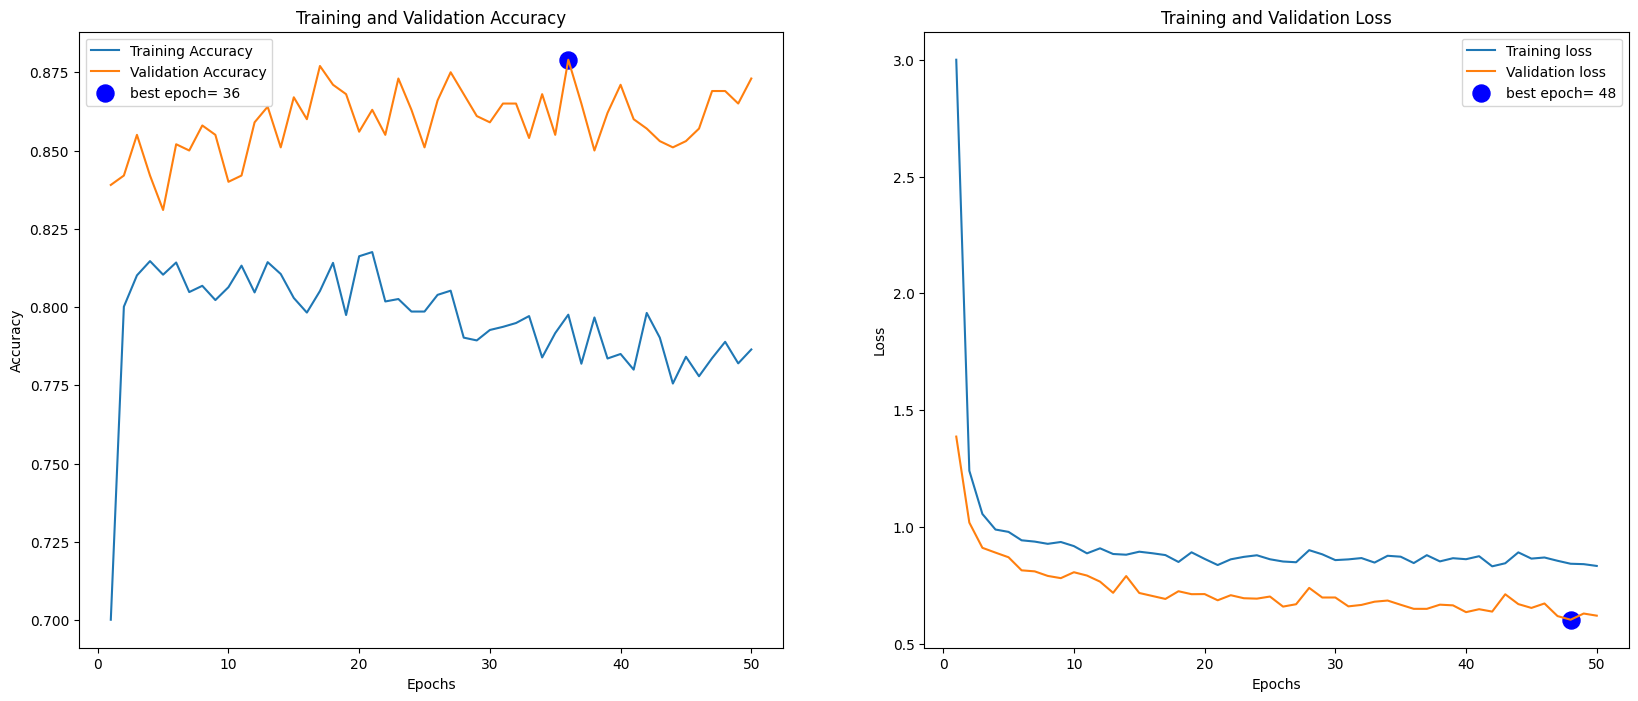

In [18]:
plot_training(history_mobilenet)

In [19]:
mobilenet.layers[0].trainable = True
mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2588490 (9.87 MB)
Trainable params: 255437

# Fine Tune

In [20]:
mobilenet.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [21]:

fine_tune_epoch = 50

total_epochs =  initial_epochs + fine_tune_epoch

history_mobilenet_fine = mobilenet.fit(x=train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_mobilenet.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[my_callbacks])

Epoch 50/100
225/225 [==============================] - 67s 178ms/step - loss: 1.5348 - accuracy: 0.5693 - val_loss: 0.7930 - val_accuracy: 0.8280
Epoch 51/100
225/225 [==============================] - 39s 172ms/step - loss: 0.9547 - accuracy: 0.7492 - val_loss: 0.8923 - val_accuracy: 0.7850
Epoch 52/100
225/225 [==============================] - 39s 174ms/step - loss: 0.8090 - accuracy: 0.8038 - val_loss: 0.9179 - val_accuracy: 0.7780
Epoch 53/100
225/225 [==============================] - 39s 172ms/step - loss: 0.7164 - accuracy: 0.8394 - val_loss: 0.8935 - val_accuracy: 0.7880
Epoch 54/100
225/225 [==============================] - 39s 174ms/step - loss: 0.6341 - accuracy: 0.8642 - val_loss: 0.8506 - val_accuracy: 0.8040
Epoch 55/100
225/225 [==============================] - 39s 173ms/step - loss: 0.5896 - accuracy: 0.8840 - val_loss: 0.7781 - val_accuracy: 0.8280
Epoch 56/100
225/225 [==============================] - 39s 173ms/step - loss: 0.5487 - accuracy: 0.8982 - val_loss: 0

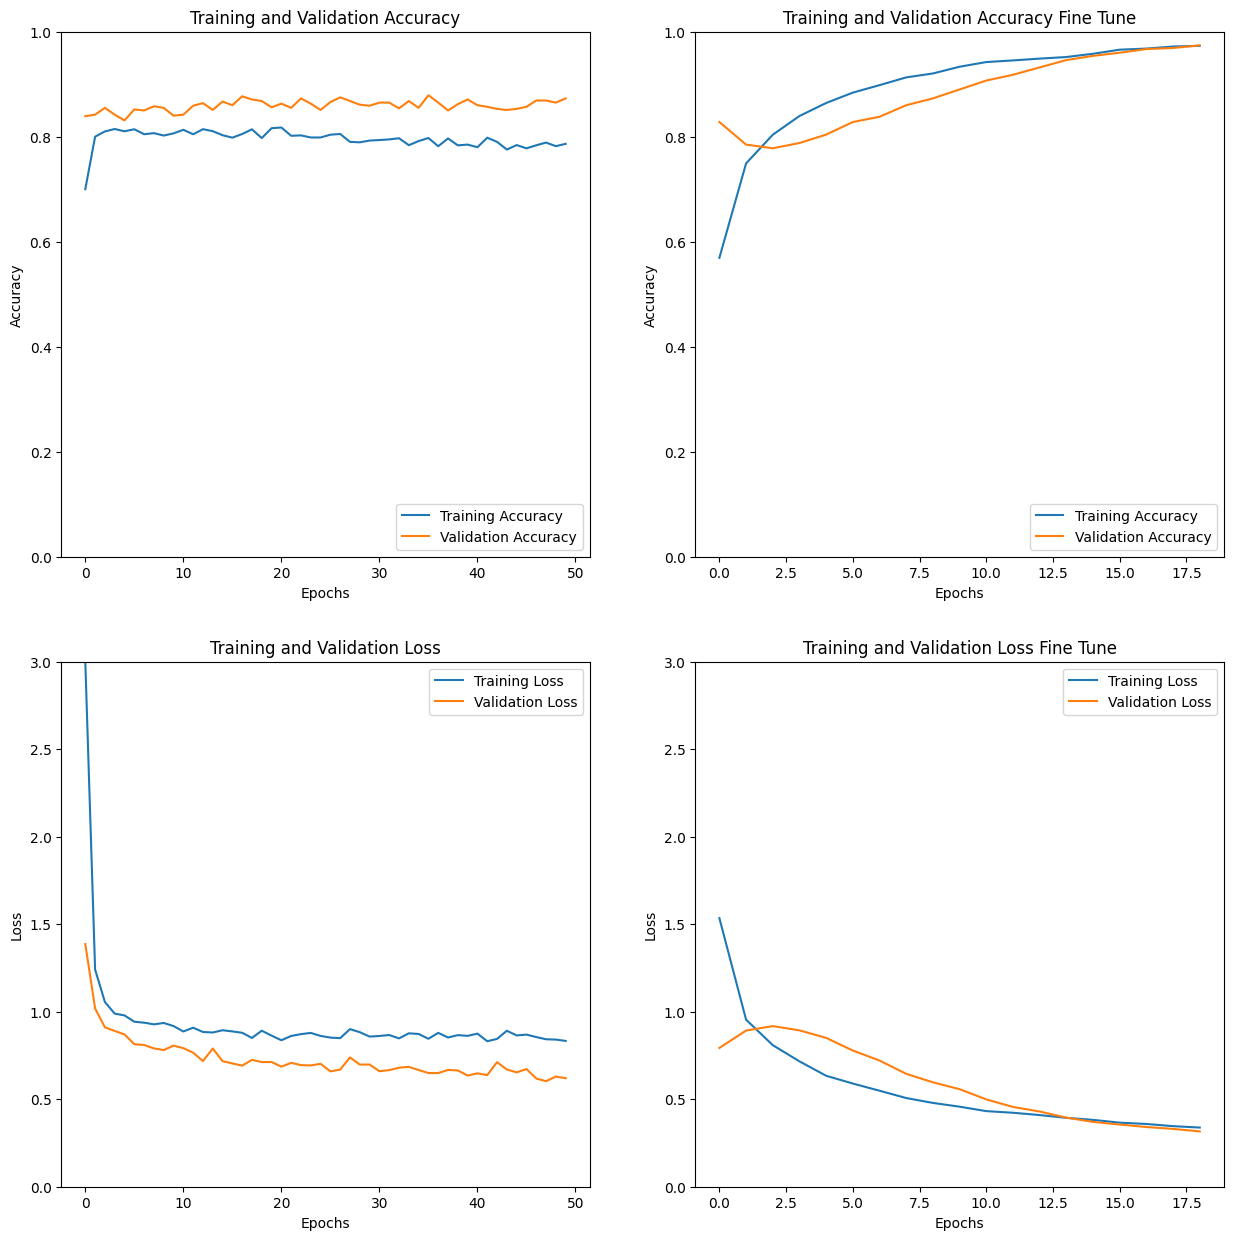

In [22]:
plt.figure(figsize= (15, 15))

plt.subplot(2, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history_mobilenet_fine.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet_fine.history['val_accuracy'], label= 'Validation Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy Fine Tune')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history_mobilenet.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')


plt.subplot(2, 2, 4)
plt.plot(history_mobilenet_fine.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet_fine.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss Fine Tune')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout
plt.show()

In [23]:
ts_length = len(test_df)
steps = ts_length // test_batch
train_score = mobilenet.evaluate(train_generator, steps=steps, verbose= 1)
valid_score = mobilenet.evaluate(validation_generator, steps=steps, verbose= 1)
test_score = mobilenet.evaluate(test_generator, steps=steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 7s 249ms/step - loss: 0.3676 - accuracy: 0.9570
Train Loss:  0.24678130447864532
Train Accuracy:  0.9987499713897705
--------------------
Validation Loss:  0.32016363739967346
Validation Accuracy:  0.9712499976158142
--------------------
Test Loss:  0.36762604117393494
Test Accuracy:  0.9570000171661377


In [25]:
preds = mobilenet.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]

20/20 [==============================] - 5s 140ms/step


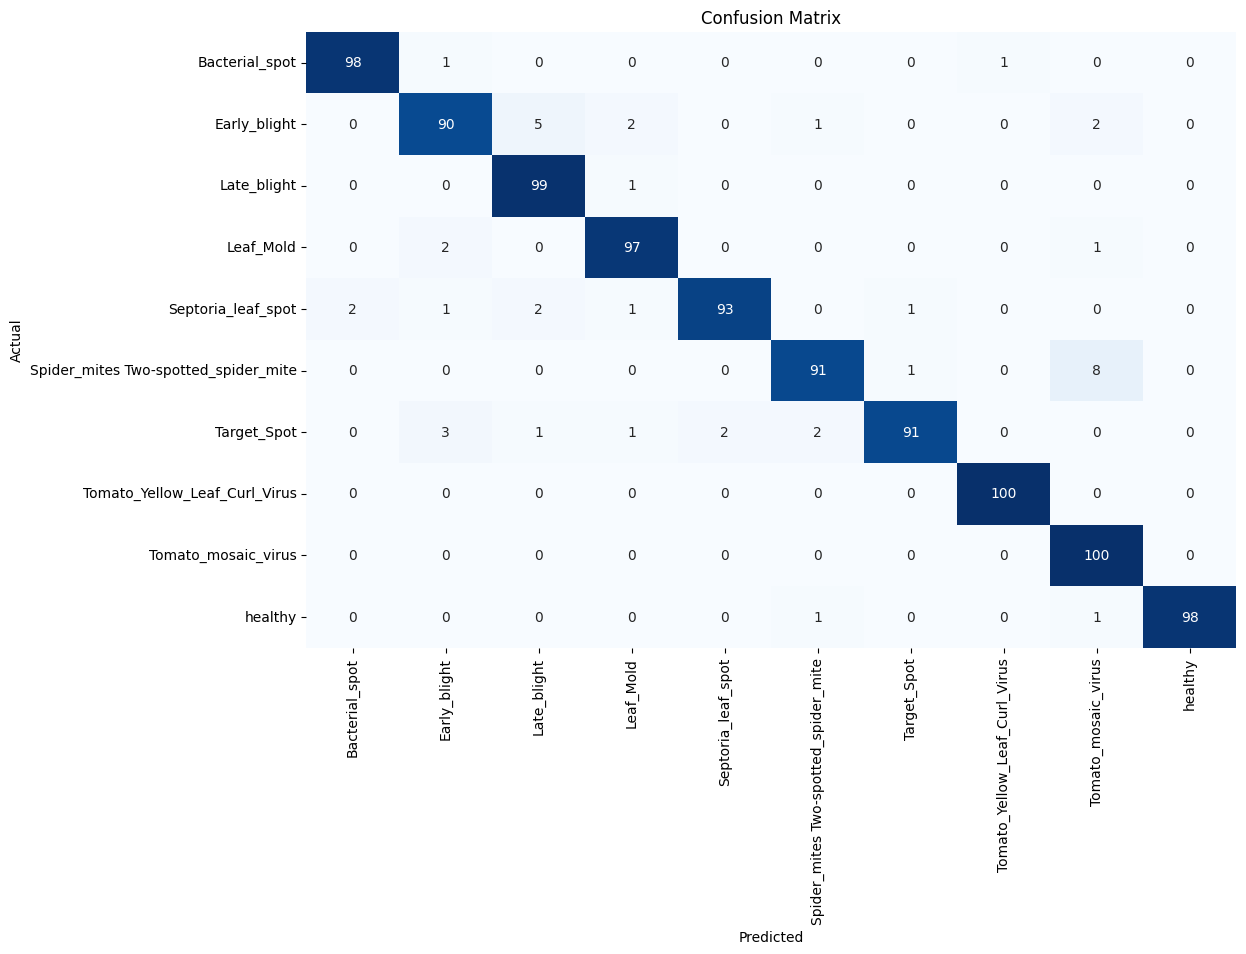


Classification Report:
----------------------
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.98      0.98       100
                        Early_blight       0.93      0.90      0.91       100
                         Late_blight       0.93      0.99      0.96       100
                           Leaf_Mold       0.95      0.97      0.96       100
                  Septoria_leaf_spot       0.98      0.93      0.95       100
Spider_mites Two-spotted_spider_mite       0.96      0.91      0.93       100
                         Target_Spot       0.98      0.91      0.94       100
       Tomato_Yellow_Leaf_Curl_Virus       0.99      1.00      1.00       100
                 Tomato_mosaic_virus       0.89      1.00      0.94       100
                             healthy       1.00      0.98      0.99       100

                            accuracy                           0.96      1000
               

In [26]:
def make_evaluation(test_gen, y_pred):
  classes = [label[9:] for label in list(test_gen.class_indices.keys())] # slice word "Tomato___"
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

make_evaluation(test_generator, y_pred)

# Inception V3

In [27]:

from keras.utils import to_categorical
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob

In [29]:
# Import the InceptionV3 model and here we will be using imagenet weights
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [30]:
# We don't need to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [31]:
# Folders in the Training Set
folders = glob('/content/images/tomato/train/*')
folders

['/content/images/tomato/train/Tomato___Leaf_Mold',
 '/content/images/tomato/train/Tomato___Septoria_leaf_spot',
 '/content/images/tomato/train/Tomato___Late_blight',
 '/content/images/tomato/train/Tomato___Tomato_mosaic_virus',
 '/content/images/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/images/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/images/tomato/train/Tomato___healthy',
 '/content/images/tomato/train/Tomato___Target_Spot',
 '/content/images/tomato/train/Tomato___Bacterial_spot',
 '/content/images/tomato/train/Tomato___Early_blight']

In [32]:
# Model layers -> can add more if required
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [33]:
# Create a model object
model = Model(inputs=inception.input, outputs=prediction)

# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [34]:
# Defining the cost and model optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [35]:
# Using the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
# Training Generator
training_set = train_datagen.flow_from_directory('/content/images/tomato/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10000 images belonging to 10 classes.


In [38]:
test_set = test_datagen.flow_from_directory('/content/images/tomato/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 10 classes.


In [39]:
# fit the model, it will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-39-b80d1d73bc9e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
313/313 [==============================] - 141s 422ms/step - loss: 3.1440 - accuracy: 0.6381 - val_loss: 2.5172 - val_accuracy: 0.7100
Epoch 2/10
313/313 [==============================] - 129s 413ms/step - loss: 2.0743 - accuracy: 0.7697 - val_loss: 2.5898 - val_accuracy: 0.7600
Epoch 3/10
313/313 [==============================] - 129s 410ms/step - loss: 1.9194 - accuracy: 0.8030 - val_loss: 2.3046 - val_accuracy: 0.7810
Epoch 4/10
313/313 [==============================] - 129s 412ms/step - loss: 1.8338 - accuracy: 0.8258 - val_loss: 3.0490 - val_accuracy: 0.7740
Epoch 5/10
313/313 [==============================] - 129s 412ms/step - loss: 1.7454 - accuracy: 0.8362 - val_loss: 2.6986 - val_accuracy: 0.7870
Epoch 6/10
313/313 [==============================] - 127s 406ms/step - loss: 1.5506 - accuracy: 0.8575 - val_loss: 2.8554 - val_accuracy: 0.7990
Epoch 7/10
313/313 [==============================] - 130s 414ms/step - loss: 1.7050 - accuracy: 0.8551 - val_loss: 3.2961 -

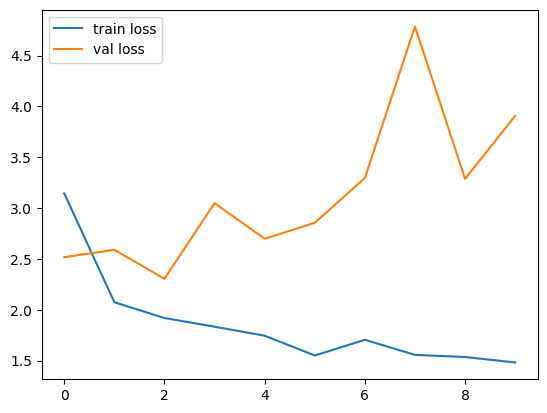

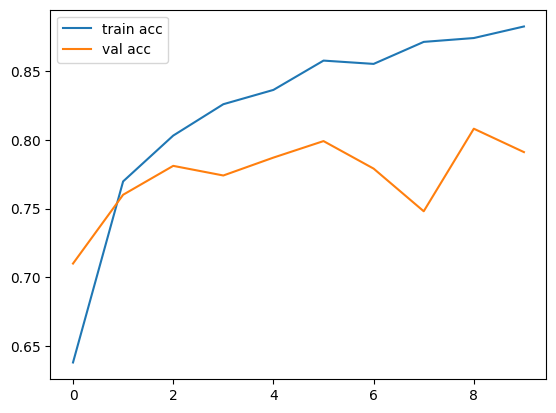

<Figure size 640x480 with 0 Axes>

In [40]:
# Plot the Loss and Accuracy
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Training and testing on Random Forest and KNN

In [53]:
# Feature extraction using MobileNetV2
mobile_features_train = mobilenet.predict(train_generator)
mobile_features_valid = mobilenet.predict(validation_generator)
mobile_features_test = mobilenet.predict(test_generator)

# Feature extraction using InceptionV3
inception_features_train = model.predict(training_set)
inception_features_valid = model.predict(test_set)
inception_features_test = model.predict(test_generator)



20/20 [==============================] - 7s 110ms/step


In [50]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit Random Forest on MobileNet features
rf_classifier.fit(mobile_features_train, train_generator.classes)

# Evaluate Random Forest
rf_train_score = rf_classifier.score(mobile_features_train, train_generator.classes)
rf_valid_score = rf_classifier.score(mobile_features_valid, test_generator.classes)
rf_test_score = rf_classifier.score(mobile_features_test, test_generator.classes)

print("Random Forest Train Accuracy:", rf_train_score)
print("Random Forest Validation Accuracy:", rf_valid_score)
print("Random Forest Test Accuracy:", rf_test_score)


Random Forest Train Accuracy: 0.9767777777777777
Random Forest Validation Accuracy: 0.088
Random Forest Test Accuracy: 0.109


In [54]:
from sklearn.neighbors import KNeighborsClassifier


# Create KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit KNN on InceptionV3 features
knn_classifier.fit(inception_features_train, training_set.classes)

# Evaluate KNN
knn_train_score = knn_classifier.score(inception_features_train, training_set.classes)
knn_valid_score = knn_classifier.score(inception_features_valid, test_set.classes)
knn_test_score = knn_classifier.score(inception_features_test, test_generator.classes)

print("KNN Train Accuracy:", knn_train_score)
print("KNN Validation Accuracy:", knn_valid_score)
print("KNN Test Accuracy:", knn_test_score)


KNN Train Accuracy: 0.3425
KNN Validation Accuracy: 0.103
KNN Test Accuracy: 0.093


32/32 [==============================] - 2s 72ms/step - loss: 3.9076 - accuracy: 0.7910


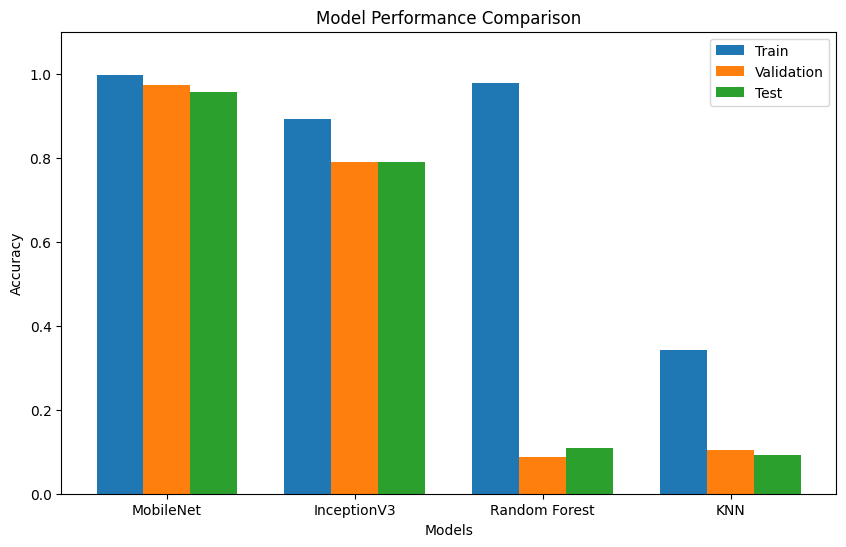

In [55]:
import matplotlib.pyplot as plt

# Define model names
models = ['MobileNet', 'InceptionV3', 'Random Forest', 'KNN']

# Define model scores
train_scores = [mobilenet.evaluate(train_generator)[1],
                model.evaluate(training_set)[1],
                rf_train_score,
                knn_train_score]

valid_scores = [mobilenet.evaluate(validation_generator)[1],
                model.evaluate(test_set)[1],
                rf_valid_score,
                knn_valid_score]

test_scores = [mobilenet.evaluate(test_generator)[1],
               model.evaluate(test_set)[1],
               rf_test_score,
               knn_test_score]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(models))

plt.bar(index, train_scores, bar_width, label='Train')
plt.bar([i + bar_width for i in index], valid_scores, bar_width, label='Validation')
plt.bar([i + 2 * bar_width for i in index], test_scores, bar_width, label='Test')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks([i + bar_width for i in index], models)
plt.legend()
plt.ylim(0, 1.1)

plt.show()
